## Queries Benchmarking

In [2]:
# plot and use numpy

import numpy as np
from matplotlib import pyplot as plt 

new_array = np.empty(10, dtype=float) ## creates an array of type float

new_array[3] = 7 # affects the 4th element

x = np.linspace(0,10,100)
y = np.sin(x)

# snippet of code to plot 2 arrays of arrays of same dimensions
plt.title("Matplotlib demo") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.plot(x,y) 
plt.show()

ModuleNotFoundError: No module named 'matplotlib'

In [29]:
# Choices

We took several parameters into account in order to provide unbiased and reproductible results. We present them in the next section.

## Time measurement

In order to measure accurately the time taken for a database CRUD operation to complete, we need to measure the duration between the moment the command is called and the moment it returns (both postgres and cassandra python API functions returns synchronuously). In addition, we measure time by several (100) batches of 100 measurements. This allows to plot the distribution of several latencies AND have precise enough measurements. 
Besides, we use the time.perf_counter function from the time module which has the best accuracy for measuring time in Python.Finally, we also clean the built-in garbage collector of Python before each measurement to ensure consistent behaviour.

## Reproducibility

Most of the queries we generate are random to limit bias in the analysis : one database system could perform surprisingly well for a specific data. Using random queries reduce such a bias. Therefore, we chose to write our queries once to a file and to perform them by reading directly the file instead of generating news random datas at each runtime execution. This let us make precise commentaries on the actual data we have observed which is the very same data you will see being displayed.

SyntaxError: invalid syntax (1522805215.py, line 3)

In [172]:
# Connec to the database and set up the table
import psycopg2
import csv
import json
import gc 
import time
import random
from psycopg2 import sql
import string


connection = psycopg2.connect(
    dbname="postgresDB", 
    user="user", 
    password="tprli", 
    host="postgres",  # Or use your database host if it's not local
    port="5432"  # Default PostgreSQL port
)
connection.autocommit = True
cursor = connection.cursor()


cursor.execute("DROP TABLE IF EXISTS bitcoin_addresses;")

# Step 2: Create the table in PostgreSQL if it doesn't exist
create_table_query = """
CREATE TABLE bitcoin_addresses (
    bitcoin_address VARCHAR(34) NOT NULL, -- Bitcoin addresses are usually 26-35 characters
    account VARCHAR(20),                 -- Account numbers, max length derived from the example
    ip_address VARCHAR(15),              -- IPv4 addresses, formatted as strings
    county VARCHAR(50),                  -- County names, variable length
    country_code CHAR(2),                -- Two-letter country codes
    database_column_type VARCHAR(50),   -- Describes column type as text (e.g., mediumint, float),
    PRIMARY KEY (bitcoin_address)
);
"""
cursor.execute(create_table_query)

In [173]:
# import data

def import_csv(path):
    with open(path, 'r') as f:
        next(f) # Skip the header row.

        gc.collect()
        start_time = time.perf_counter()
        cursor.copy_from(f, 'bitcoin_addresses', sep=",")
        end_time = time.perf_counter()
    return end_time - start_time

import_time = import_csv('/home/data.csv')

print("data succesfully imported")

data succesfully imported


In [88]:
def get_random_key():
    """
    Returns a random key from the table 
    """
    cursor.execute("""
        SELECT bitcoin_address FROM bitcoin_addresses ORDER BY RANDOM() LIMIT 1;
    """)
    return cursor.fetchone()

('10YP6UCZM1SACWVYAWHQE3ZD3JK06MLEK',)


NameError: name 'random_string' is not defined

In [ ]:
# delete

def delete_entry(key):
    """
    Deletes the entry whose key is key and returns the time needed for this operation
    """
    gc.collect()
    start_time = time.perf_counter()
    cursor.execute("""
        DELETE FROM bitcoin_addresses WHERE bitcoin_address = %s;
    """, key)
    end_time = time.perf_counter()

    return end_time - start_time

print(delete_entry(get_random_key()))

In [ ]:
# read

def read_entry(keys: list):
    """
    Reads all columns related to the entry whose keys are in keys and returns the time needed for retrieving the value
    """
    gc.collect()
    start_time = time.perf_counter()

    for key in keys:
        cursor.execute("""
            SELECT * FROM bitcoin_addresses WHERE bitcoin_address = %s
        """, key)

    end_time = time.perf_counter()

    return end_time - start_time

print(read_entry(get_random_key()))

# postgres select



# we go through the file and measure the time taken for
# selecting 100 queries as much time as there are queries in the file

select_path = "select_primary_key_0.sql"
with open(select_path, 'r') as file:
    lines = file.readlines()
    n_iter = int(len(lines)/100)
    postgres_times_select = np.empty(n_iter)

    for i in range(n_iter):
        gc.collect()
        start_time = time.perf_counter()
        for j in range(100):
            # should we take into account loop overhead ?
            line = lines[i*100 +j]
            cursor.execute(line)
        end_time = time.perf_counter()
        postgres_time_select[i] = end_time - start_time


     






In [182]:
# update

def get_random_string(length):
    caracteres = string.ascii_letters + string.digits
    return ''.join(random.choices(caracteres, k=length))

print(get_random_string(10))

def update_entry(key):
    """
    Update all columns related to the entry whose key is key with random values and returns the time needed for updating the entry
    """
    ip_address = get_random_string(15)
    county = get_random_string(50)
    country_code = get_random_string(2)
    database_column_type = get_random_string(5)

    gc.collect()
    start_time = time.perf_counter()
    cursor.execute("""
        UPDATE bitcoin_addresses
        SET ip_address = %s, county = %s, country_code = %s, database_column_type = %s
        WHERE bitcoin_address = %s
    """, (ip_address, county, country_code, database_column_type, key))
    end_time = time.perf_counter()

    return end_time - start_time

print(update_entry(get_random_key()))

3HAYvsQFvJ


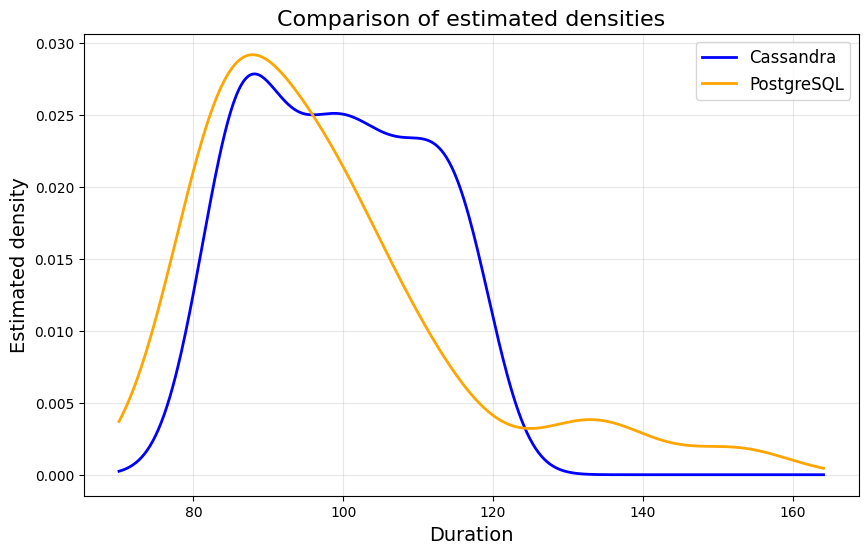

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Exemple de deux listes numpy représentant des latences
latences1 = np.random.uniform(80, 120, 100)  # Distribution uniforme
latences2 = np.random.exponential(20, 100) + 80  # Distribution exponentielle décalée

# Estimation de la densité pour chaque ensemble de données
x = np.linspace(min(latences1.min(), latences2.min()) - 10, 
                max(latences1.max(), latences2.max()) + 10, 500)
density1 = gaussian_kde(latences1)
density2 = gaussian_kde(latences2)

# Tracer les enveloppes des courbes de densité
plt.figure(figsize=(10, 6))
plt.plot(x, density1(x), label='Cassandra', color='blue', linewidth=2)
plt.plot(x, density2(x), label='PostgreSQL', color='orange', linewidth=2)

# Ajout des légendes et des titres
plt.title('Comparison of estimated densities', fontsize=16)
plt.xlabel('Duration', fontsize=14)
plt.ylabel('Estimated density', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Affichage
plt.show()


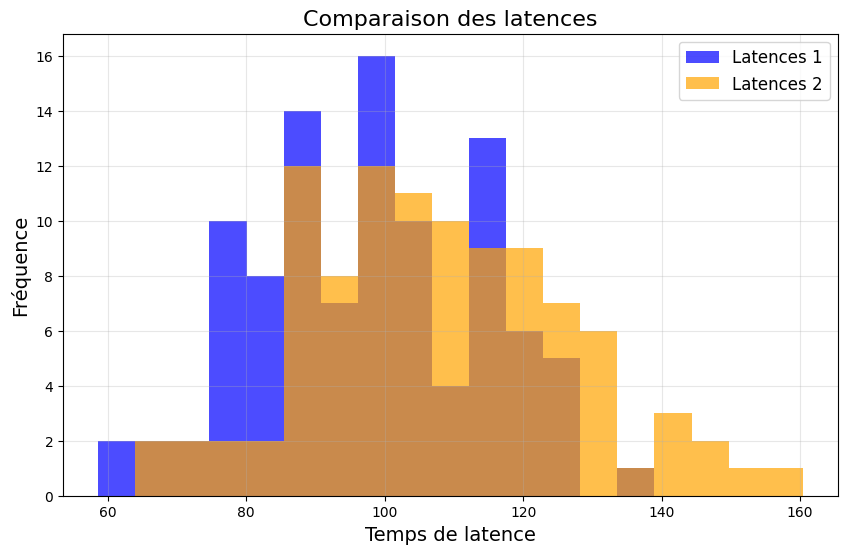

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de deux listes numpy représentant des latences
latences1 = np.random.normal(100, 15, 100)  # Exemple de données pour la première liste
latences2 = np.random.normal(110, 20, 100)  # Exemple de données pour la deuxième liste

# Déterminer les bornes communes
min_bin = min(latences1.min(), latences2.min())
max_bin = max(latences1.max(), latences2.max())
bins = np.linspace(min_bin, max_bin, 20)  # 20 bins entre les valeurs min et max

# Création de l'histogramme avec des bornes communes
plt.figure(figsize=(10, 6))
plt.hist(latences1, bins=bins, alpha=0.7, label='Latences 1', color='blue')
plt.hist(latences2, bins=bins, alpha=0.7, label='Latences 2', color='orange')

# Ajout des légendes et des titres
plt.title('Comparaison des latences', fontsize=16)
plt.xlabel('Temps de latence', fontsize=14)
plt.ylabel('Fréquence', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Affichage
plt.show()


In [ ]:
# insert / create

def add_entry():
    """
    Add an entry with default values and a new key and returns the time taken for that operation.
    We handle the case where the key was already in the database by calling the function once again.
    Eventually the code will return.
    """

    bitcoin_address = get_random_string(33)
    account = get_random_string(20)
    ip_address = get_random_string(15)
    county = get_random_string(50)
    country_code = get_random_string(2)
    database_column_type = get_random_string(5)

    try:
        gc.collect()
        start_time = time.perf_counter()
        cursor.execute("""
            INSERT INTO bitcoin_addresses
            VALUES (%s, %s, %s, %s, %s, %s)
        """, (bitcoin_address, account, ip_address, county, country_code, database_column_type))
        end_time = time.perf_counter()
        return end_time - start_time
    except:
        return add_entry()

    

print(add_entry())